<a href="https://colab.research.google.com/github/user5254532/Whisper-1/blob/master/FT_clip_on_wine_bottles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openai-clip

In [2]:
#For Parsing json data
import json

#For Loading Images
from PIL import Image

#For displaying loadbar
from tqdm import tqdm

#Importing pytorch to finetune our clip
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

#Here, we import clip model developed by meta
import clip

#Constructs a CLIP processor which wraps a CLIP image processor and a CLIP tokenizer into a single processor.
from transformers import CLIPProcessor, CLIPModel

#1. Load dataset

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# image Paths
image_path = '/content/drive/MyDrive/Dr Aha_Data_Shared/data/img/'
# text csv
text_path='/content/drive/MyDrive/Dr Aha_Data_Shared/data/defect_df.csv'


In [5]:
# read the csv as data frame
import pandas as pd
df0=pd.read_csv(text_path)

In [6]:
df0.head(3)

,Unnamed: 0,defect_name,defect_id,defect_tags,defect_position,defect_description,defect_image_url_ls,high_res_url
0,0,Deformed Finish,NaN,\n\n\n/\n \n\n - \n\n\n\n,Finish,"\n\nA finish, which has a deformed appearance....",['https://glassopenbook.com/uploads/defect_ima...,['https://glassopenbook.com/uploads/defect_ima...
1,1,Broken Finish,NaN,\n\n\n/\n \n\n - \n\n\n\t\t\t\t\t#Snipped Fini...,Finish,\n\nA small section of glass has broken away f...,['https://glassopenbook.com/uploads/defect_ima...,['https://glassopenbook.com/uploads/defect_ima...
2,2,Stuck Plug,NaN,"\n\n\n/\n \n\n - \n\n\n\t\t\t\t\t#Hot Plug, #P...",Finish,"\n\nA piece of glass, which looks like a small...",['https://glassopenbook.com/uploads/defect_ima...,['https://glassopenbook.com/uploads/defect_ima...


In [7]:
df=df0[['defect_name', 'defect_position','high_res_url']]

In [8]:
df.head(3)

,defect_name,defect_position,high_res_url
0,Deformed Finish,Finish,['https://glassopenbook.com/uploads/defect_ima...
1,Broken Finish,Finish,['https://glassopenbook.com/uploads/defect_ima...
2,Stuck Plug,Finish,['https://glassopenbook.com/uploads/defect_ima...


In [9]:
len(df)

103

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   defect_name      103 non-null    object
 1   defect_position  103 non-null    object
 2   high_res_url     103 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


In [11]:
#calulate the number of images in each defect
col=[len(i.split()) for i in df['high_res_url']]
col[:5], len(col)

([8, 8, 2, 9, 9], 103)

In [12]:
sum(col)

1230

In [13]:
df.insert(3, 'defect_image_number', col)

In [14]:
df.head(5)

,defect_name,defect_position,high_res_url,defect_image_number
0,Deformed Finish,Finish,['https://glassopenbook.com/uploads/defect_ima...,8
1,Broken Finish,Finish,['https://glassopenbook.com/uploads/defect_ima...,8
2,Stuck Plug,Finish,['https://glassopenbook.com/uploads/defect_ima...,2
3,Dirty Finish,Finish,['https://glassopenbook.com/uploads/defect_ima...,9
4,Chipped Thread,Finish,['https://glassopenbook.com/uploads/defect_ima...,9


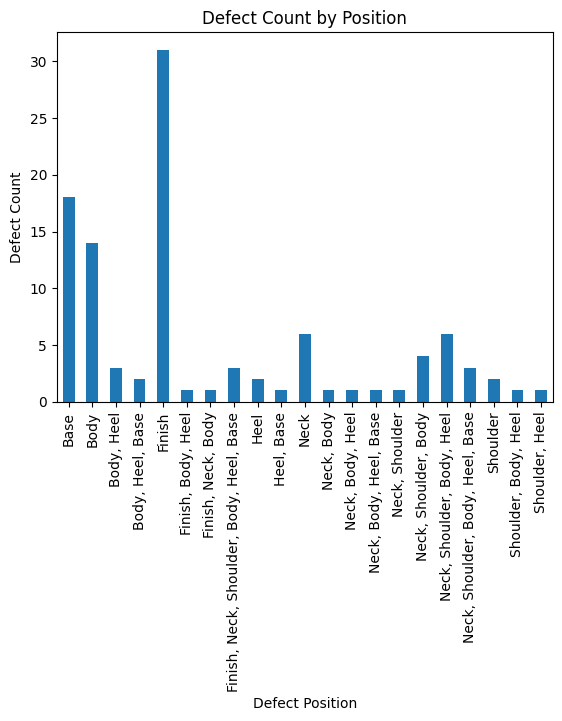

In [15]:
# defect count by position
import matplotlib.pyplot as plt
df.groupby('defect_position')['defect_name'].count().plot(kind='bar')
plt.title('Defect Count by Position')
plt.xlabel('Defect Position')
_ = plt.ylabel('Defect Count')

# Build the dataset for clip
##### Get the image corresponding to its defect name
Example on one

In [16]:
import re
pattern = r'(\d+)_(\d+)\.png$'
#url=urls.split()[7]
url = 'https://glassopenbook.com/uploads/defect_images/apegg_bb_101_5600388186984.png'
match=re.search(pattern, url)
image_name=match.group()

In [17]:
image=Image.open(image_path+image_name)

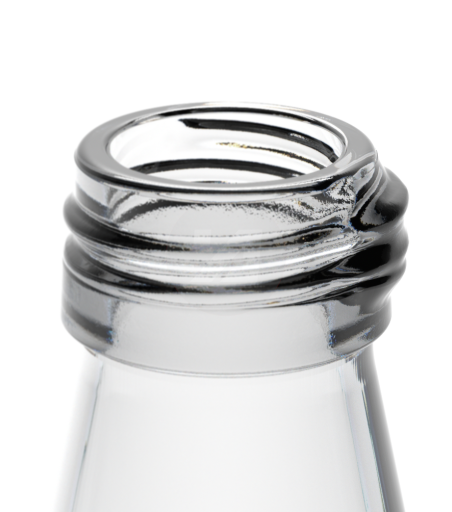

In [18]:
image

##### Batch process to build the dataset

In [49]:
list_image_path=[]
list_txt=[]
pattern = r'(\d+)_[a-zA-Z\d]+\.png$'

In [51]:
for i in range(len(df)):#### test for 2
  urls=df['high_res_url'][i][1:-1].replace("'","").split(',')  # need to remove '[' and ']' at the front and the end
  for j in urls:
    list_txt.append(df['defect_name'][i])
    match=re.search(pattern, j)  # need to remove "'" and "'" at the front and the end
    list_image_path.append(image_path+match.group())

In [52]:
j

' https://glassopenbook.com/uploads/defect_images/apegg_nnpb_405_58f0e4b373297.png'

In [53]:
print(len(list_image_path))
print(len(list_txt))

2460
2460


In [224]:
# # Load the CLIP model and processor
#model_original = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
#processor_original = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [54]:
# Choose computation device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"device is {device}")

device is cuda:0


# 2. Load the pretrained model and preprocess

In [21]:
# Load pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=0, jit=False)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.2MiB/s]


In [ ]:
model_original

In [ ]:
processor_original

In [22]:
model, preprocess

(CLIP(
   (visual): VisionTransformer(
     (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
     (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
     (transformer): Transformer(
       (resblocks): Sequential(
         (0): ResidualAttentionBlock(
           (attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
           )
           (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
           (mlp): Sequential(
             (c_fc): Linear(in_features=768, out_features=3072, bias=True)
             (gelu): QuickGELU()
             (c_proj): Linear(in_features=3072, out_features=768, bias=True)
           )
           (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         )
         (1): ResidualAttentionBlock(
           (attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, 

In [28]:
class image_title_dataset():
    def __init__(self, list_image_path,list_txt):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.title  = clip.tokenize(list_txt)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        return image, title

In [55]:
dataset = image_title_dataset(list_image_path, list_txt)

In [56]:
dataset[0]

(tensor([[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],
 
         [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          ...,
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],
 
         [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459, 2.1459,  ...,

In [57]:
train_dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

# 3. Train the model

In [58]:
# Function to convert model's parameters to FP32 format
#This is done so that our model loads in the provided memory.
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

In [59]:
# Check if the device is set to CPU
#if device == "cpu":
#    model.float()  # Convert the model's parameters to float if using CPU

In [60]:
# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6 ,weight_decay=0.2)

# Adam optimizer is used with specific hyperparameters
# lr (learning rate) is set to 5e-5, which is considered safe for fine-tuning to a new dataset
# betas are used for the optimization algorithm
# eps is a small value to prevent division by zero
# weight_decay adds L2 regularization to the optimizer

# Specify the loss function for images
loss_img = nn.CrossEntropyLoss()

# Specify the loss function for text
loss_txt = nn.CrossEntropyLoss()

In [61]:
num_epochs = 1 # Number of training epochs
for epoch in range(num_epochs):

    pbar = tqdm(train_dataloader, total=len(train_dataloader))

    # Iterate through the batches in the training data
    for batch in pbar:
        optimizer.zero_grad()  # Zero out gradients for the optimizer

        # Extract images and texts from the batch
        images, texts = batch

        # Print the current device (CPU or GPU)
        print(device)

        # Move images and texts to the specified device (CPU or GPU)
        images = images.to(device)
        texts = texts.to(device)

        # Forward pass through the model
        logits_per_image, logits_per_text = model(images, texts)

        # Compute the loss
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2

        # Backward pass and update the model's parameters
        total_loss.backward()

        # If the device is CPU, directly update the model
        if device == "cpu":
            optimizer.step()
        else:
            # Convert model's parameters to FP32 format, update, and convert back
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        # Update the progress bar with the current epoch and loss
        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

  0%|          | 0/25 [00:00<?, ?it/s]

cuda:0


Epoch 0/1, Loss: 4.6875:   8%|▊         | 2/25 [01:53<21:28, 56.02s/it]

cuda:0


Epoch 0/1, Loss: 4.6094:  12%|█▏        | 3/25 [02:48<20:22, 55.58s/it]

cuda:0


Epoch 0/1, Loss: 4.6914:  16%|█▌        | 4/25 [03:37<18:28, 52.80s/it]

cuda:0


Epoch 0/1, Loss: 4.5859:  20%|██        | 5/25 [04:29<17:30, 52.53s/it]

cuda:0


Epoch 0/1, Loss: 4.5625:  24%|██▍       | 6/25 [05:15<15:54, 50.22s/it]

cuda:0


Epoch 0/1, Loss: 4.5156:  28%|██▊       | 7/25 [05:59<14:29, 48.28s/it]

cuda:0


Epoch 0/1, Loss: 4.3047:  32%|███▏      | 8/25 [06:39<12:57, 45.72s/it]

cuda:0


Epoch 0/1, Loss: 4.2578:  36%|███▌      | 9/25 [07:19<11:41, 43.84s/it]

cuda:0


Epoch 0/1, Loss: 4.2500:  40%|████      | 10/25 [08:00<10:43, 42.89s/it]

cuda:0


Epoch 0/1, Loss: 4.2266:  44%|████▍     | 11/25 [08:33<09:21, 40.10s/it]

cuda:0


Epoch 0/1, Loss: 4.0469:  48%|████▊     | 12/25 [09:05<08:08, 37.60s/it]

cuda:0


Epoch 0/1, Loss: 4.1016:  52%|█████▏    | 13/25 [09:32<06:50, 34.22s/it]

cuda:0


Epoch 0/1, Loss: 3.8730:  56%|█████▌    | 14/25 [09:56<05:42, 31.14s/it]

cuda:0


Epoch 0/1, Loss: 4.0352:  60%|██████    | 15/25 [10:25<05:04, 30.44s/it]

cuda:0


Epoch 0/1, Loss: 3.8770:  64%|██████▍   | 16/25 [10:48<04:15, 28.42s/it]

cuda:0


Epoch 0/1, Loss: 3.9180:  68%|██████▊   | 17/25 [11:14<03:39, 27.50s/it]

cuda:0


Epoch 0/1, Loss: 3.9258:  72%|███████▏  | 18/25 [11:33<02:56, 25.17s/it]

cuda:0


Epoch 0/1, Loss: 3.8203:  76%|███████▌  | 19/25 [11:53<02:20, 23.44s/it]

cuda:0


Epoch 0/1, Loss: 3.4883:  80%|████████  | 20/25 [12:06<01:41, 20.28s/it]

cuda:0


Epoch 0/1, Loss: 3.7188:  84%|████████▍ | 21/25 [12:19<01:12, 18.04s/it]

cuda:0


Epoch 0/1, Loss: 3.4102:  88%|████████▊ | 22/25 [12:31<00:48, 16.33s/it]

cuda:0


Epoch 0/1, Loss: 3.2578:  92%|█████████▏| 23/25 [12:37<00:26, 13.31s/it]

cuda:0


Epoch 0/1, Loss: 3.4316:  96%|█████████▌| 24/25 [12:42<00:10, 10.61s/it]

cuda:0


Epoch 0/1, Loss: 2.9277: 100%|██████████| 25/25 [12:43<00:00, 30.55s/it]

cuda:0
